# <center>User identification


In [2]:
from datetime import datetime, timedelta
from glob import glob
import os
import re

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tqdm import tqdm


%matplotlib inline

In this task we will solve the problem of user identification: the algorithm will analyze a sequence of several websites visited consecutively by the same person and determine whether it is Alice or an attacker (someone else). As data, we have the visited websites and the date of visit.

# 1. Initial data review

First, let's load the data.

In [2]:
PATH_TO_DATA = 'data'

In [29]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

In [4]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


We have data in the form of sessions of length 10, time of visit and user ID.  The sites are encoded with integers. You can see that some sessions are missing data. This means that the user visited less than 10 sites per session.

Let's combine the test and training samples for further transformations.

In [31]:
train_test_df = pd.concat([train_df, test_df], sort=False)

In [98]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
site1     253561 non-null int64
time1     253561 non-null object
site2     250098 non-null float64
time2     250098 non-null object
site3     246919 non-null float64
time3     246919 non-null object
site4     244321 non-null float64
time4     244321 non-null object
site5     241829 non-null float64
time5     241829 non-null object
site6     239495 non-null float64
time6     239495 non-null object
site7     237297 non-null float64
time7     237297 non-null object
site8     235224 non-null float64
time8     235224 non-null object
site9     233084 non-null float64
time9     233084 non-null object
site10    231052 non-null float64
time10    231052 non-null object
target    253561 non-null int64
dtypes: float64(9), int64(2), object(10)
memory usage: 42.6+ MB


You can see that some data is missing. This occurs where sessions are shorter than 10.

In [45]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

There are 2297 sessions of the target user and 251264 sessions of other users in the training sample. The class imbalance is very strong, and looking at the proportion of correct answers (accuracy) is not representative. Instead, we will use roc auc.

# 2. Data preprocessing

First, let's look at the visited sites. We need to get rid of the gaps in the data. The site indexes were numbered from 1, so let's replace the gaps with zeros.

In [33]:
sites =['site%d' % i for i in range(1, 11)]
train_test_df_sites = train_test_df[sites].fillna(0).astype('int')
train_test_df_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0
2,890,941,3847,941,942,3846,3847,3846,1516,1518
3,14769,39,14768,14769,37,39,14768,14768,14768,14768
4,782,782,782,782,782,782,782,782,782,782
5,22,177,175,178,177,178,175,177,177,178


The resulting numerical data themselves are meaningless as features in a classification task. Sites cannot be compared and subtracted. Sites can be treated as words in text analysis and a bag of words (sites) can be used. Each site will have its own column and the value in the column is equal to the number of visits in the current session. Since there will be a lot of columns and no visited sites and most of the values will be zeros, we will store the data in sparse matrices *scipy.csr_matrix*.

In [7]:
def to_csr(X):
    '''
    Take matrix with visited sites and return corespond csr_matrix.
    '''
    data = [] #site counts
    indices = [] #column index
    indptr = [0] #count of values in row
    for i in range(len(X)):
        counts_in_row = np.unique(X[i], return_counts=True)
        data.extend(counts_in_row[1])
        indptr.append(indptr[-1] + counts_in_row[1].shape[0])
        indices.extend(counts_in_row[0])

    return csr_matrix((data, indices, indptr), shape=(len(X), max(max(X, key=lambda x: max(x))) + 1))[:, 1:]

In [12]:
train_test_sparse = to_csr(train_test_df_sites.values)
X_train_sparse = train_test_sparse[:len(train_df)]
X_test_sparse = train_test_sparse[len(train_df):]

In [97]:
y = train_df['target']

Let's save `X_train_sparse`, `X_test_sparse` and `y` arrays to pickle files.

In [48]:
with open(os.path.join(PATH_TO_DATA, 'X_train_sparse.pkl'), 'wb') as X_train_sparse_pkl:
    pickle.dump(X_train_sparse, X_train_sparse_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'X_test_sparse.pkl'), 'wb') as X_test_sparse_pkl:
    pickle.dump(X_test_sparse, X_test_sparse_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'train_target.pkl'), 'wb') as train_target_pkl:
    pickle.dump(y, train_target_pkl, protocol=2)

In [6]:
with open(os.path.join(PATH_TO_DATA, 'X_train_sparse.pkl'), 'rb') as X_train_sparse_pkl:
    X_train_sparse = pickle.load(X_train_sparse_pkl)
with open(os.path.join(PATH_TO_DATA, 'X_test_sparse.pkl'), 'rb') as X_test_sparse_pkl:
    X_test_sparse = pickle.load(X_test_sparse_pkl)
with open(os.path.join(PATH_TO_DATA, 'train_target.pkl'), 'rb') as train_target_pkl:
    y = pickle.load(train_target_pkl)

# 3. Adding new features

New features to consider include:
- **hour** - session beginning hour;
- **day** - session beginning day;
- **day_of_week** - session beginning day of the week;
- **month** - session beginning month;
- **sessoin_time** - session length in seconds.

In [8]:
def feature_engineering(data):
    dataframe = data.copy()
    for column in ['time%d' % i for i in range(1, 11)]:
        dataframe[column] = pd.to_datetime(dataframe[column], format='%Y-%m-%d %H:%M:%S')
    
    for i in range(1, 10):
        dataframe['diff%d' % i] = (dataframe['time%d' % (i+1)] - dataframe['time%d' % i]).dt.total_seconds()    
    
    dataframe['session_time'] = dataframe.loc[:, ['diff%d' % i for i in range(1, 10)]].sum(axis=1)
    dataframe['month'] = dataframe['time1'].dt.month
    dataframe['day'] = dataframe['time1'].dt.day
    dataframe['day_of_week'] = dataframe['time1'].dt.dayofweek
    dataframe['hour'] = dataframe['time1'].dt.hour
    dataframe.drop(['time%d' % i for i in range(1, 11)], axis=1, inplace=True)
    dataframe.fillna(0, inplace=True)
    
    return dataframe

In [35]:
train_test_df_featured = feature_engineering(train_test_df)
train_test_df_featured.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,diff5,diff6,diff7,diff8,diff9,session_time,month,day,day_of_week,hour
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2,20,3,10
2,890,941.0,3847.0,941.0,942.0,3846.0,3847.0,3846.0,1516.0,1518.0,...,0.0,1.0,0.0,23.0,1.0,26.0,2,22,5,11
3,14769,39.0,14768.0,14769.0,37.0,39.0,14768.0,14768.0,14768.0,14768.0,...,0.0,1.0,1.0,1.0,2.0,7.0,12,16,0,16
4,782,782.0,782.0,782.0,782.0,782.0,782.0,782.0,782.0,782.0,...,30.0,30.0,30.0,30.0,30.0,270.0,3,28,4,10
5,22,177.0,175.0,178.0,177.0,178.0,175.0,177.0,177.0,178.0,...,36.0,0.0,0.0,67.0,5.0,246.0,2,28,4,10


Let's look at the obtained features distributions. Since the classes are strongly unbalanced, we normalize them before displaying.

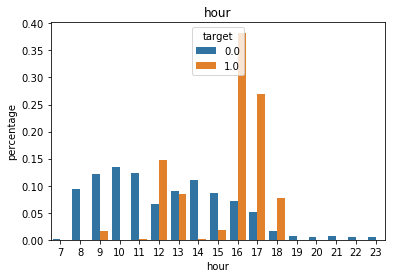

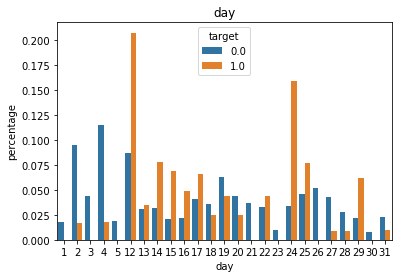

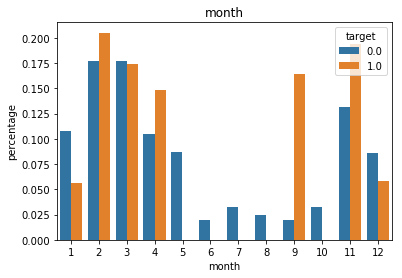

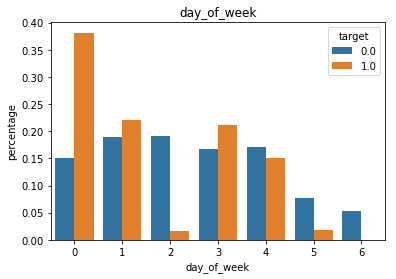

In [165]:
for feature in ['hour', 'day', 'month', 'day_of_week']:
    data = train_test_df_featured.groupby(['target'])[feature].value_counts(normalize=True).rename('percentage').reset_index()
    sns.barplot(x=feature, y='percentage', hue='target', data=data);
    plt.title(feature)
    plt.show();

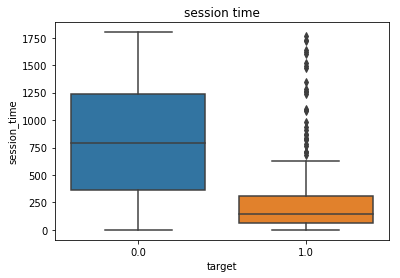

In [64]:
data = train_test_df_featured.groupby(['target'])['session_time'].value_counts().rename('percentage').reset_index()
sns.boxplot(x='target', y='session_time', data=data);
plt.title('session time')
plt.show();

* **hour** - hours of operation are only given from 7 to 23. Alice only has hours between 9 and 18. The main difference from other users is strong activity at 16 and 17 hours.
* **day** - Alice has days with no activity and strong activity on the 12th and 24th, unlike other users.
* **month** - the same as with days, there are months without activity, although other users have a decrease in activity at this time. This decline falls in the summer and is probably related to vacations and travel (although it also includes September and October).
* **day_of_week** - Alice has no activity on Sunday and little activity on Wednesday and Saturday. Unlike other users, there is a lot of activity on Monday.
* **session_time** - on average Alice has a much shorter session length, but there are many outliers.

These features are differentiate Alice from other users and are worth trying to use for training.

Since these features are categorical, they should be encoded using one-hot-encoding, where each value of a categorical feature is assigned a binary value.

In [36]:
train_test_sparse_df = pd.get_dummies(train_test_df_featured.loc[:, 'month':], 
                                      columns=['month', 'day', 'day_of_week', 'hour'], prefix='')

Let's combine the resulting bag of words and the new features.

In [17]:
train_test_sparse_concat = hstack((train_test_sparse, csr_matrix(train_test_sparse_df.values)), 'csr')

In [18]:
X_train_sparse = train_test_sparse_concat[:len(train_df)]
X_test_sparse = train_test_sparse_concat[len(train_df):]
y = train_df['target']

In [70]:
with open(os.path.join(PATH_TO_DATA, 'X_train_sparse_featured.pkl'), 'wb') as X_train_sparse_pkl:
    pickle.dump(X_train_sparse, X_train_sparse_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'X_test_sparse_featured.pkl'), 'wb') as X_test_sparse_pkl:
    pickle.dump(X_test_sparse, X_test_sparse_pkl, protocol=2)

In [9]:
with open(os.path.join(PATH_TO_DATA, 'X_train_sparse_featured.pkl'), 'rb') as X_train_sparse_pkl:
    X_train_sparse = pickle.load(X_train_sparse_pkl)
with open(os.path.join(PATH_TO_DATA, 'X_test_sparse_featured.pkl'), 'rb') as X_test_sparse_pkl:
    X_test_sparse = pickle.load(X_test_sparse_pkl)
with open(os.path.join(PATH_TO_DATA, 'train_target.pkl'), 'rb') as train_target_pkl:
    y = pickle.load(train_target_pkl)

Let's divide the training sample into 2 parts without mixing. The initial data are ordered by time and the test set is clearly separated from the training set by time. We will keep the same here.

In [10]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

# 4. Models training

Let's try to train the SGDClassifier model without parameter tuning on the given data. Since our classes are strongly unbalanced, we need to specify `class_weight='balanced'`.

In [11]:
%%time
sgd_logit = SGDClassifier('log', random_state=17, n_jobs=-1, tol=1e-3, max_iter=1000, class_weight='balanced')
sgd_logit.fit(X_train, y_train)

Wall time: 880 ms


In [12]:
sgd_valid_pred_prob = sgd_logit.predict_proba(X_valid)
roc_auc_score(y_valid, sgd_valid_pred_prob[:, 1])

0.9850250141466161

The result looks very good. Next, let's try to tune the parameters. Create a function to draw validation curves after GridSearchCV start.

In [20]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

In [120]:
%%time
param_grid = {
    'alpha':[1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
}
grid_cv = GridSearchCV(SGDClassifier('log', random_state=17, n_jobs=-1, shuffle=False, 
                                     tol=1e-3, max_iter=1000, class_weight='balanced'), 
                       param_grid, n_jobs=-1, cv=5, scoring='roc_auc', return_training_score=True)
grid_cv.fit(X_train, y_train)

Wall time: 10.4 s


In [121]:
grid_cv.best_params_

{'alpha': 0.0001}

In [122]:
grid_cv.best_score_

0.9851807201343414

Let's look at a graph of the dependence roc-auc from `C`.

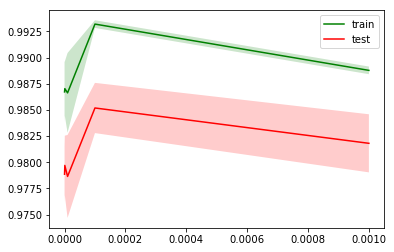

In [123]:
plot_validation_curves(param_grid['alpha'], grid_cv.cv_results_)

The graph shows that after reaching the value of `alpha` equal to 1e-4, roc auc starts to fall. It means that the optimal value of the parameter was reached. Also on the graph there is no strong convergence between training and test samples, so the model is not overfitting.

Let's check the model on the validation set.

In [124]:
sgd_logit = grid_cv.best_estimator_
sgd_valid_pred_prob = sgd_logit.predict_proba(X_valid)
roc_auc_score(y_valid, sgd_valid_pred_prob[:, 1])

0.9851692985111218

The resulting score is almost the same as the initial result.

In [46]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [18]:
sgd_logit.fit(X_train_sparse, y)
logit_test_pred_proba = sgd_logit.predict_proba(X_test_sparse)

In [21]:
write_to_submission_file(logit_test_pred_proba[:, 1], 
                        os.path.join(PATH_TO_DATA, 'submission.csv'))

Score on kaggle: **0.93443**.

This is less than the training, maybe there are other ways to improve it.

## 4.1 TimeSeriesSplit

Our data are time related, so we should sort them and use **TimeSeriesSplit** for cross-validation. Unlike simple cross-validation, where data are split randomly, **TimeSeriesSplit** uses data incrementally. First, a small sample is taken from the beginning and following it for testing. Then the test and validation samples are merged and the next test sample is taken. This will allow us to take into account the relationship over time in our sample. All steps will be the same, only sorting and using **TimeSeriesSplit** will be added.

<center><img src=https://hsto.org/webt/8i/5k/vx/8i5kvxrehatyvf-l3glz_-ymhtw.png>

In [48]:
train_df.sort_values(by='time1', inplace=True)
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [49]:
train_test_df = pd.concat([train_df, test_df], sort=False)

In [50]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')
train_test_df_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [51]:
train_test_sparse = to_csr(train_test_df_sites.values)
X_train_sparse = train_test_sparse[:len(train_df)]
X_test_sparse = train_test_sparse[len(train_df):]

In [52]:
train_test_df_featured = feature_engineering(train_test_df)
train_test_df_featured.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,diff5,diff6,diff7,diff8,diff9,session_time,month,day,day_of_week,hour
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,12,5,8
54843,56,55.0,56.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1786.0,1,12,5,8
77292,946,946.0,951.0,946.0,946.0,945.0,948.0,784.0,949.0,946.0,...,0.0,0.0,0.0,1.0,0.0,4.0,1,12,5,8
114021,945,948.0,949.0,948.0,945.0,946.0,947.0,945.0,946.0,946.0,...,0.0,1.0,0.0,0.0,1.0,3.0,1,12,5,8
146670,947,950.0,948.0,947.0,950.0,952.0,946.0,951.0,946.0,947.0,...,0.0,0.0,1.0,0.0,0.0,2.0,1,12,5,8


In [53]:
train_test_sparse_df = pd.get_dummies(train_test_df_featured.loc[:, 'session_time':], 
                                      columns=['month', 'day', 'day_of_week', 'hour'], prefix='')

In [86]:
train_test_sparse_concat = hstack((train_test_sparse, csr_matrix(train_test_sparse_df.values)), 'csr')

In [87]:
X_train_sparse = train_test_sparse_concat[:len(train_df)]
X_test_sparse = train_test_sparse_concat[len(train_df):]

In [14]:
y = train_df['target']

In [75]:
with open(os.path.join(PATH_TO_DATA, 'X_train_sparse_sorted.pkl'), 'wb') as X_train_sparse_pkl:
    pickle.dump(X_train_sparse, X_train_sparse_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'X_test_sparse_sorted.pkl'), 'wb') as X_test_sparse_pkl:
    pickle.dump(X_test_sparse, X_test_sparse_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'train_target_sorted.pkl'), 'wb') as train_target_pkl:
    pickle.dump(y, train_target_pkl, protocol=2)

In [108]:
with open(os.path.join(PATH_TO_DATA, 'X_train_sparse_sorted.pkl'), 'rb') as X_train_sparse_pkl:
    X_train_sparse = pickle.load(X_train_sparse_pkl)
with open(os.path.join(PATH_TO_DATA, 'X_test_sparse_sorted.pkl'), 'rb') as X_test_sparse_pkl:
    X_test_sparse = pickle.load(X_test_sparse_pkl)
with open(os.path.join(PATH_TO_DATA, 'train_target_sorted.pkl'), 'rb') as train_target_pkl:
    y = pickle.load(train_target_pkl)

In [88]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

We use **TimeSeriesSplit** instead of the standard cross-validation option.

In [15]:
time_split = TimeSeriesSplit(5)

In [97]:
%%time
param_grid = {
    'alpha':np.linspace(1e-7, 1e-3, 100)
}
grid_cv = GridSearchCV(SGDClassifier('log', random_state=17, shuffle=False, 
                                     class_weight='balanced', tol=1e-3), 
                       param_grid, n_jobs=-1, cv=time_split, scoring='roc_auc', return_train_score=True)
grid_cv.fit(X_train, y_train)

Wall time: 55.5 s


In [98]:
grid_cv.best_params_

{'alpha': 0.0009191999999999999}

In [99]:
grid_cv.best_score_

0.7128896658828486

In [100]:
sgd_logit = grid_cv.best_estimator_
sgd_valid_pred_prob = sgd_logit.predict_proba(X_valid)
roc_auc_score(y_valid, sgd_valid_pred_prob[:, 1])

C:\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


0.778472865654642

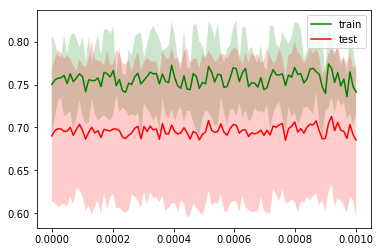

In [101]:
plot_validation_curves(param_grid['alpha'], grid_cv.cv_results_)

The classifier is not training at all, according to the graph. Let's try another model - **LogisticRegression**.

In [102]:
%%time
param_grid = {
    'C':np.logspace(-2, 2, 10)    
}

grid_cv = GridSearchCV(LogisticRegression(random_state=17, class_weight='balanced'), 
                       param_grid, n_jobs=-1, cv=time_split, scoring='roc_auc',
                      verbose=1, return_train_score=True)
grid_cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.3min finished


Wall time: 2min 27s


In [103]:
grid_cv.best_params_

{'C': 0.0774263682681127}

In [104]:
grid_cv.best_score_

0.9232202076126066

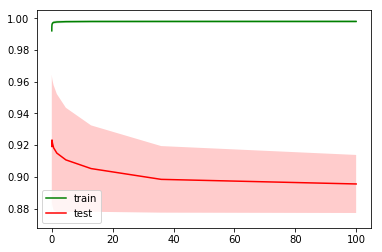

In [107]:
plot_validation_curves(param_grid['C'], grid_cv.cv_results_)

In [105]:
logit_reg = grid_cv.best_estimator_
logit_valid_pred_prob = logit_reg.predict_proba(X_valid)
roc_auc_score(y_valid, logit_valid_pred_prob[:, 1])

0.9506951606428773

LogisticRegression is able to classify with acceptable accuracy. Although the result on the validation set is smaller than at the beginning, but let's see the result on kaggle.

In [56]:
%%time
logit_reg.fit(X_train_sparse, y)
logit_test_pred_proba = logit_reg.predict_proba(X_test_sparse)

Wall time: 14.1 s


In [57]:
write_to_submission_file(logit_test_pred_proba[:, 1], 
                        os.path.join(PATH_TO_DATA, 'submission.csv'))

Score on kaggle: **0.94013**. 

That is higher than previous one.

## 4.2 TfIdf

The available data represents a set of sequentially visited sites. This is similar to the sequence of words in a text. Using this similarity we can apply the method used for texts - Tfidf. In the visit history, as in a text, there may be stop words (sites) that probably do not carry important information. This method will allow to exclude such words (sites).

In [54]:
tfidf_vector = TfidfVectorizer(max_features=50000, ngram_range=(1, 3))
text_df = train_test_df_sites.astype(np.str).apply(' '.join, axis=1)
words = tfidf_vector.fit_transform(text_df.values)
words

C:\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


<336358x50000 sparse matrix of type '<class 'numpy.float64'>'
	with 4433718 stored elements in Compressed Sparse Row format>

In [55]:
train_test_sparse_concat = hstack((words, csr_matrix(train_test_sparse_df)), 'csr')

In [56]:
X_train_sparse = train_test_sparse_concat[:len(train_df)]
X_test_sparse = train_test_sparse_concat[len(train_df):]
y = train_df['target']

In [81]:
with open(os.path.join(PATH_TO_DATA, 'X_train_sparse_sorted_tfidf.pkl'), 'wb') as X_train_sparse_pkl:
    pickle.dump(X_train_sparse, X_train_sparse_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'X_test_sparse_sorted_tfidf.pkl'), 'wb') as X_test_sparse_pkl:
    pickle.dump(X_test_sparse, X_test_sparse_pkl, protocol=2)

In [58]:
with open(os.path.join(PATH_TO_DATA, 'X_train_sparse_sorted_tfidf.pkl'), 'rb') as X_train_sparse_pkl:
    X_train_sparse = pickle.load(X_train_sparse_pkl)
with open(os.path.join(PATH_TO_DATA, 'X_test_sparse_sorted_tfidf.pkl'), 'rb') as X_test_sparse_pkl:
    X_test_sparse = pickle.load(X_test_sparse_pkl)

In [57]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

In [82]:
%%time
param_grid = {
    'C':np.logspace(-2, 2, 10)    
}

grid_cv = GridSearchCV(LogisticRegression(random_state=17, class_weight='balanced'), 
                       param_grid, n_jobs=-1, cv=time_split, scoring='roc_auc',
                      verbose=1, return_train_score=True)
grid_cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.3min finished


Wall time: 2min 28s


In [83]:
grid_cv.best_params_

{'C': 0.5994842503189409}

In [84]:
grid_cv.best_score_

0.924175260317651

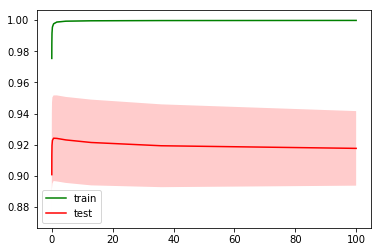

In [85]:
plot_validation_curves(param_grid['C'], grid_cv.cv_results_)

In [69]:
logit_reg = grid_cv.best_estimator_
logit_valid_pred_prob = logit_reg.predict_proba(X_valid)
roc_auc_score(y_valid, logit_valid_pred_prob[:, 1])

0.9441677590401508

The changes on the validation set are small. Let's check on kaggle.

In [70]:
%%time
logit_reg.fit(X_train_sparse, y)
logit_test_pred_proba = logit_reg.predict_proba(X_test_sparse)

Wall time: 15.8 s


In [71]:
write_to_submission_file(logit_test_pred_proba[:, 1], 
                        os.path.join(PATH_TO_DATA, 'submission.csv'))

Score on kaggle: **0.94771**. 

This is better than the previous result. The assumption that our data is similar to the text can be considered justified. It can be seen that the roc auc value in the model without data sorting is higher, but the final result is lower.

# Conclusion

The objective of this paper was to identify a particular user on the basis of user's browsing history. For this purpose different models were considered and the best one was selected based on roc auc metric. In order to maximize the result, the data was analyzed and then transformed and new features were added. Logistic Regression model with time sorting of data and application of tfidf showed the best result. In addition, the following attributes were used as features:
- **hour**;
- **day**;
- **day_of_week**;
- **month**;
- **sessoin_time**.

If we look at the work as a whole, we can say that the task of classifying one user from a set of others is quite feasible with acceptable accuracy, but far from 1. It is quite possible to use model ensembles for this task in future.